# Example Plotting Jupyter file

Maybe add animation and multiyear capabilities

In [ ]:
# Import necessary libraries
import numpy as np
import geopandas as gpd
import osmnx as ox
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import housing_model_functions as hm  # Python file with all functions
import warnings
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt


warnings.filterwarnings('ignore')

## Define City and District data

### Data Imports (OSMNX)

In [2]:
warnings.filterwarnings('ignore')

# Define New York City as city to be analyzed
place_name = "New York City"

# OSMNX Public data downloads:

# Download district borders. Here make sure admin level matches district level by observing borders df
borders = ox.features_from_place(place_name, tags={"boundary": "administrative", "admin_level": "8"})

# Probably there will be repeated districts in the df so just select the desired ones with a similar method as below. Perhaps changing 'ref' column name and the end of range to num of districts + 1.
districts_within_city = borders[borders['name'].isin(['The Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'])]

# Gets city boundary
city_boundary = ox.geocode_to_gdf(place_name, which_result = 1) 

# Gets districts within city boundary
districts_within_city = gpd.sjoin(districts_within_city, city_boundary, how = "inner", predicate = 'within')
districts_within_city = districts_within_city[['name_left', 'geometry']].rename(columns={'name_left': 'District'})

# Download the road network data and Convert to GeoDataFrame for easier manipulation
road_df = ox.graph_from_place(place_name, network_type = "drive")
road_df = ox.graph_to_gdfs(road_df, nodes = False)

# Download parks (Only include named parks with polygon and multipolygon shapes to reduce amenity saturation)
parks = ox.features_from_place(place_name, tags = {"leisure" : "park"})
parks = parks[parks.geometry.type.isin(['Polygon', 'MultiPolygon'])]
parks = parks[~parks['name'].isna()]
parks = parks[['geometry']]
parks['Type'] = 'park'

# Download schools
schools = ox.features_from_place(place_name, tags = {'amenity' : 'school'})
schools = schools[['geometry']]
schools['Type'] = 'school'

# Download supermarkets
supermarkets = ox.features_from_place(place_name, tags = {'shop' : 'supermarket'})
supermarkets = supermarkets[['geometry']]
supermarkets['Type'] = 'supermarket'

# Download landmarks
landmarks = ox.features_from_place(place_name, tags = {'tourism' : ['attraction', 'gallery', 'artwork', 'viewpoint']})
landmarks = landmarks[['geometry']]
landmarks['Type'] = 'landmark'

# Create joint amenity DataFrame
amenities_df = pd.concat([parks, schools, supermarkets, landmarks], axis=0)
amenities_df = gpd.sjoin(amenities_df, districts_within_city, how = "left", predicate = 'within')
amenities_df = amenities_df.rename(columns={'name_left': 'District'})
amenities_df = amenities_df.dropna(subset=['geometry', 'Type', 'District'])
amenities_df = amenities_df[['geometry', 'Type', 'District']]

# Download residential areas
residential_areas = ox.features_from_place(
    place_name, tags = {'building': ['apartments', 'bungalow', 'cabin', 'detached', 'annexe', 'farm', 'house', 'houseboat', 'residential', 'semidetached_house', 'terrace']})
residential_areas = gpd.GeoDataFrame(residential_areas['geometry'])
residential_areas = gpd.sjoin(residential_areas, districts_within_city, how = "inner", predicate = 'within')
residential_areas = residential_areas[['geometry', 'District']]

# Following Lines are necessary for accurate centroid calculation for agent placing

# Convert Residential from coordinate to metric system. Note: epsg defines the coordinate system we want to use.
projected_residence = residential_areas.to_crs(epsg=2263)

# Extract centroids from the geometry column for comparison
projected_residence['centroid'] = projected_residence['geometry'].centroid
projected_residence = projected_residence[['centroid', 'District']]

# Convert centroids back to geographic coordinates 
projected_residence = projected_residence['centroid'].to_crs(epsg=4326)
projected_residence = gpd.GeoDataFrame(projected_residence)

# Extract latitude and longitude from centroids
projected_residence[['latitude', 'longitude']] = projected_residence['centroid'].apply(
                lambda point: pd.Series([point.y, point.x])
            )
projected_residence['District'] = residential_areas['District']

# Reduce the data to only necessary columns and reset index 
residences_reduced = projected_residence[['latitude', 'longitude', 'District']]
residences_reduced = residences_reduced.reset_index(drop=True)

### Data Imports (From Researched Data Excel)

In [3]:
# Researched Price Data Import:

# Import NYC data from auxiliary excel file. Ensure excel file is in same folder as code.
file_name = "NYC_data.xlsx"

# Import Borough Price Data
yearly_prices = pd.read_excel(file_name, sheet_name= 'Price Data' ,index_col = 0)

# Import Population Data
population = pd.read_excel(file_name, sheet_name= 'Population Data' ,index_col = 0)

# Import Income Data
income = pd.read_excel(file_name, sheet_name= 'Income Data')

# Import Housing Growth Data
growth_rate = pd.read_excel(file_name, sheet_name= 'Housing Growth (2017-2021)' ,index_col = 0)

# Adapt population and income dataframes to work with model
population, income = hm.model_conversions(population,income)

## Set initial distribution parameters and initialize grid

In [10]:
# Set parameters 
year = 2019
affluence_vals = np.array(income.iloc[:,0])  # Affluence group parameters 
affluence_dist = np.array(income.iloc[:,1]) # Initial affluence proportions 
num_agents = 1000 # Specify the number of agents to be placed
num_amenities = 200 # Specify the number of amenities to be placed
weight = .80
districts = list(yearly_prices.columns) 
median_price = np.median(yearly_prices.loc[year]) 

amenity_multiplier = {
    'park': .2 * median_price,
    'school': .4 * median_price,
    'supermarket': .1 * median_price,
    'landmark': .3 * median_price
}

# Call initialize function
model_agents, model_amenities, radius, amenity_radius = hm.grid_initializer(num_agents, num_amenities, population, affluence_vals, affluence_dist, residences_reduced, amenities_df)
initial_prices = hm.initial_price_dist(model_agents, year, yearly_prices)

### Plot initial grid

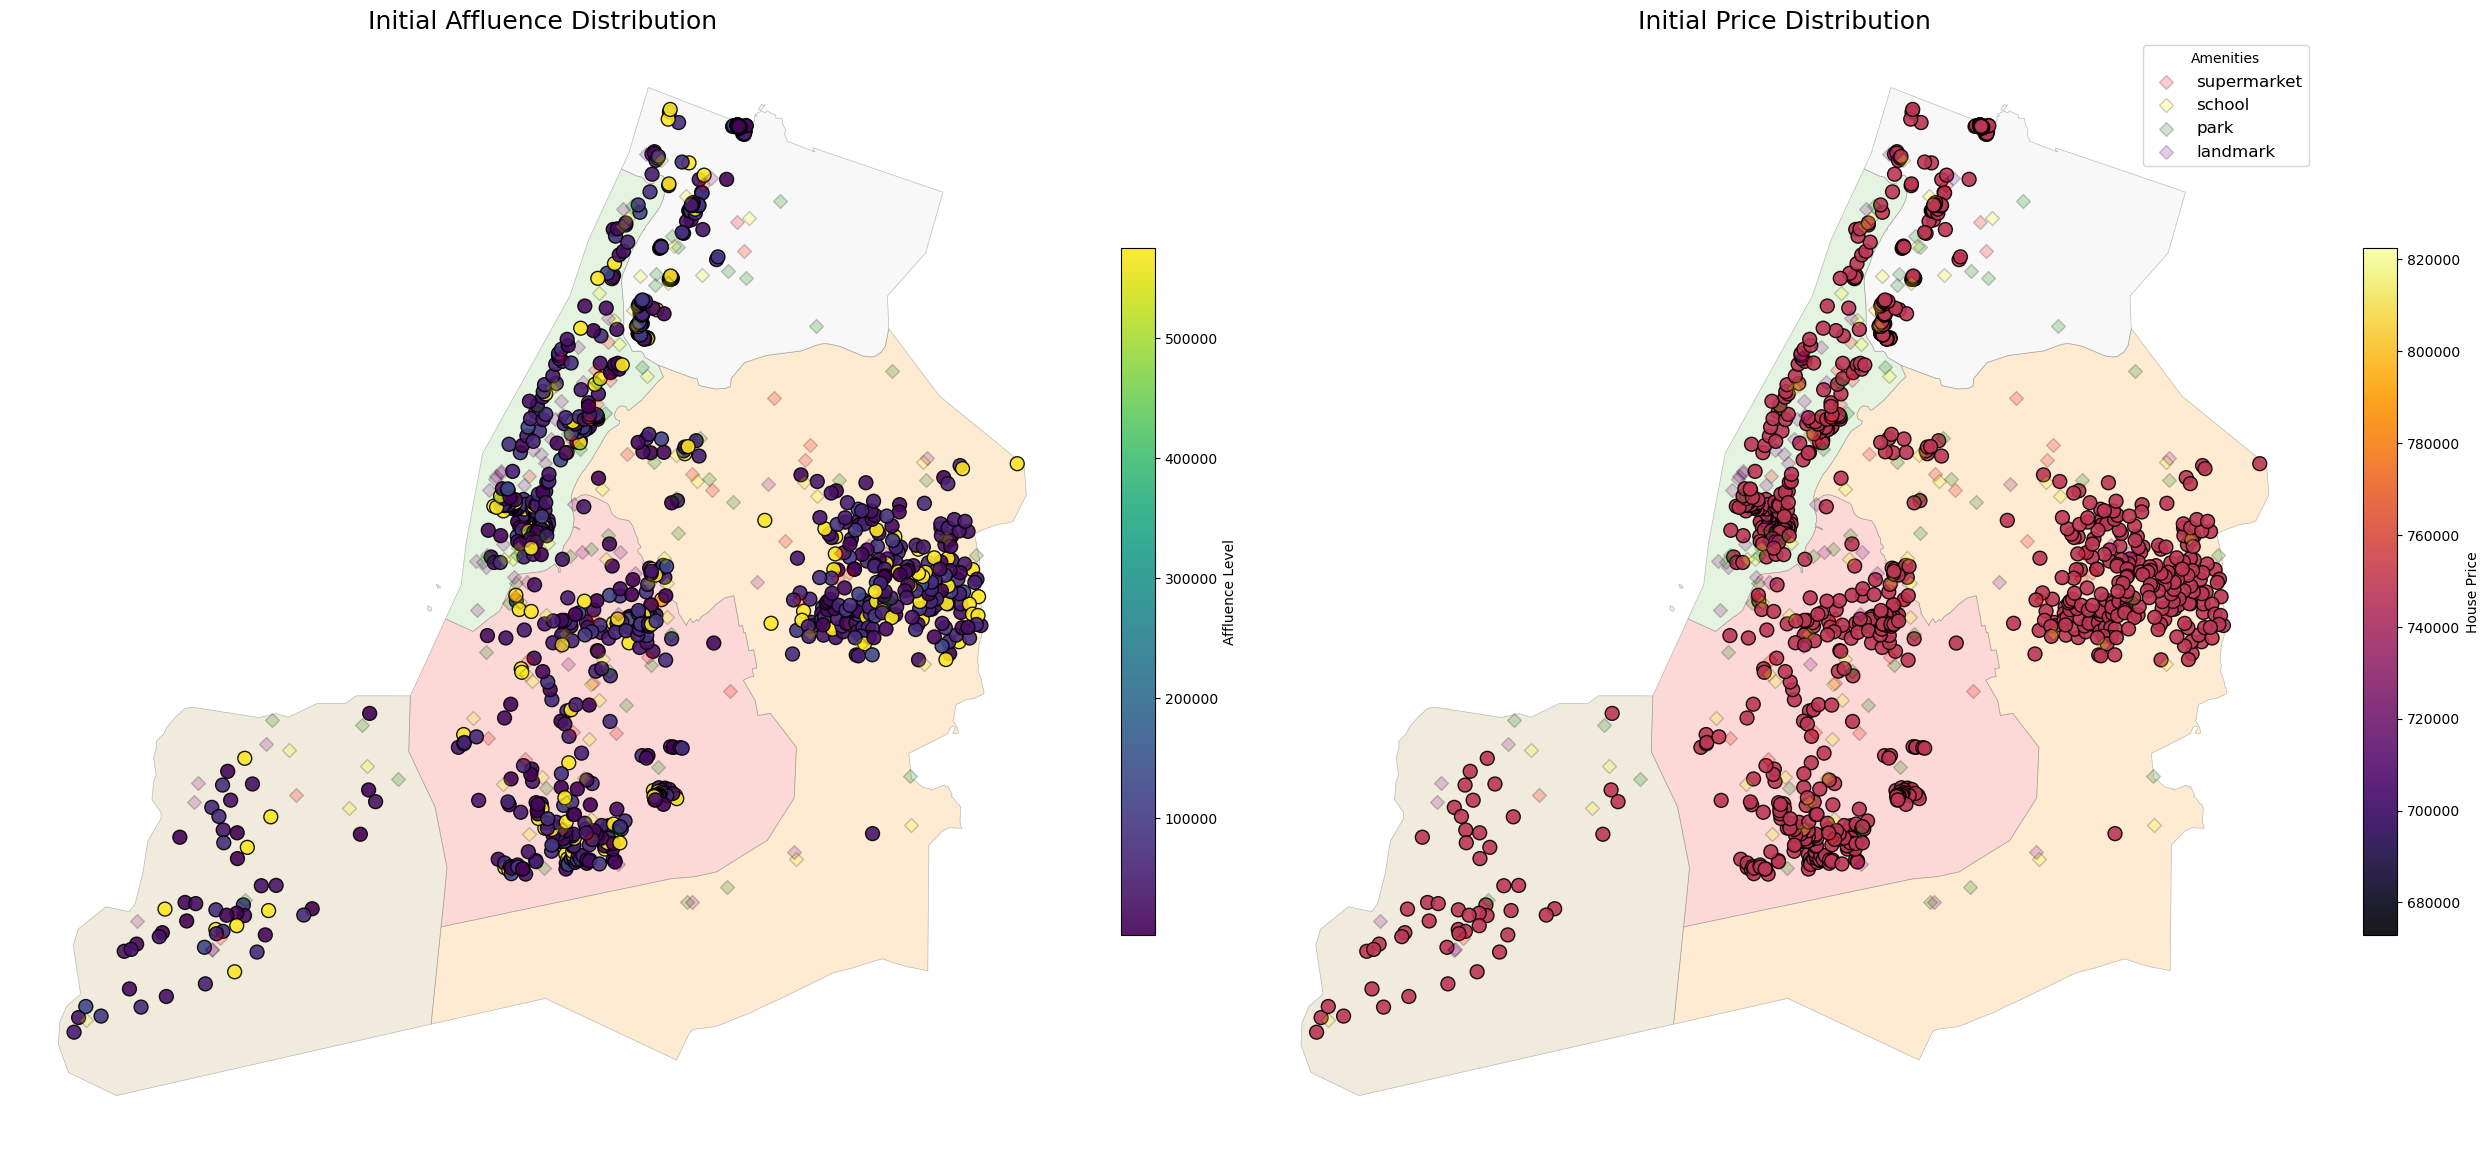

In [11]:
# Set up figure with two large subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 15), gridspec_kw={'width_ratios': [1, 1]})

# Plot the residential areas and districts on both subplots

districts_within_city.plot(ax = ax1, column = 'District', cmap = 'Pastel1', edgecolor = 'gray', linewidth = 0.5, alpha = 0.5)
districts_within_city.plot(ax = ax2, column = 'District', cmap = 'Pastel1', edgecolor = 'gray', linewidth = 0.5, alpha = 0.5)

amenity_colors = {
    'supermarket': 'red',  
    'school': 'yellow',  
    'park': 'green', 
    'landmark': 'purple'
}

# Scatter plot for ax1
for amenity_type, color in amenity_colors.items():
    # Filter model_amenities by amenity type
    filtered_amenities = model_amenities[model_amenities['Type'] == amenity_type]
    
    # Scatter plot with edge colors, marker style, and alpha set to 0.2 for transparency
    ax1.scatter(filtered_amenities['longitude'], filtered_amenities['latitude'], 
                edgecolors='k', marker='D', color=color, 
                label=amenity_type, s=50, zorder=5, alpha=0.2)

# Scatter plot for ax2
for amenity_type, color in amenity_colors.items():
    
    # Filter model_amenities by amenity type
    filtered_amenities = model_amenities[model_amenities['Type'] == amenity_type]
    

    ax2.scatter(filtered_amenities['longitude'], filtered_amenities['latitude'], 
                edgecolors='k', marker='D', color=color, 
                label=amenity_type, s=50, zorder=5, alpha=0.2)
        
# Plot the initial affluence distribution
scatter_affluence = ax1.scatter(model_agents['longitude'], model_agents['latitude'], 
                                c=model_agents['affluence'], cmap='viridis', s=100, 
                                edgecolors='k', alpha=0.9)
ax1.set_title("Initial Affluence Distribution", fontsize=18)
cbar_affluence = fig.colorbar(scatter_affluence, ax=ax1, fraction=0.03, pad=0.04, label='Affluence Level')  # Smaller color bar
ax1.axis("off")

# Plot the initial price distribution
scatter_price = ax2.scatter(initial_prices['longitude'], initial_prices['latitude'], 
                            c=initial_prices['price'], cmap='inferno', s=100, 
                            edgecolors='k', alpha=0.9)

ax2.set_title("Initial Price Distribution", fontsize=18)
plt.legend(loc='upper right', title="Amenities", fontsize=12)
cbar_price = fig.colorbar(scatter_price, ax=ax2, fraction=0.03, pad=0.04, label='House Price')  # Smaller color bar
ax2.axis("off")
plt.tight_layout()
plt.show()

### Run iterations

In [12]:
# List to store DataFrame snapshots at each timestep
saved_steps = []
saved_steps.append(initial_prices)

# Do the first house values calculation
vals = hm.update_house_prices(initial_prices, weight, radius, model_amenities, amenity_multiplier, amenity_radius)
saved_steps.append(vals)
# Set the iterations limit
n_iterations = 24

# Calculate number of agents to add at each iteration
for i in range(n_iterations):
   vals,_, swap_tot = hm.new_iteration(vals, weight, radius, model_amenities, amenity_multiplier, amenity_radius)
   
   if i == n_iterations // 2 and year in [2017,2018,2019,2020]:  # Add agents halfway through the loop
      available_residences, yearly_agents_added = hm.available_residences(vals,districts,residences_reduced, growth_rate)
      vals = hm.add_agents(vals,radius,yearly_agents_added,available_residences,affluence_vals,affluence_dist, year, yearly_prices)
      print(f"{sum(yearly_agents_added)} agents added!")
   saved_steps.append(vals)

14 agents added!


### Plot final Grid

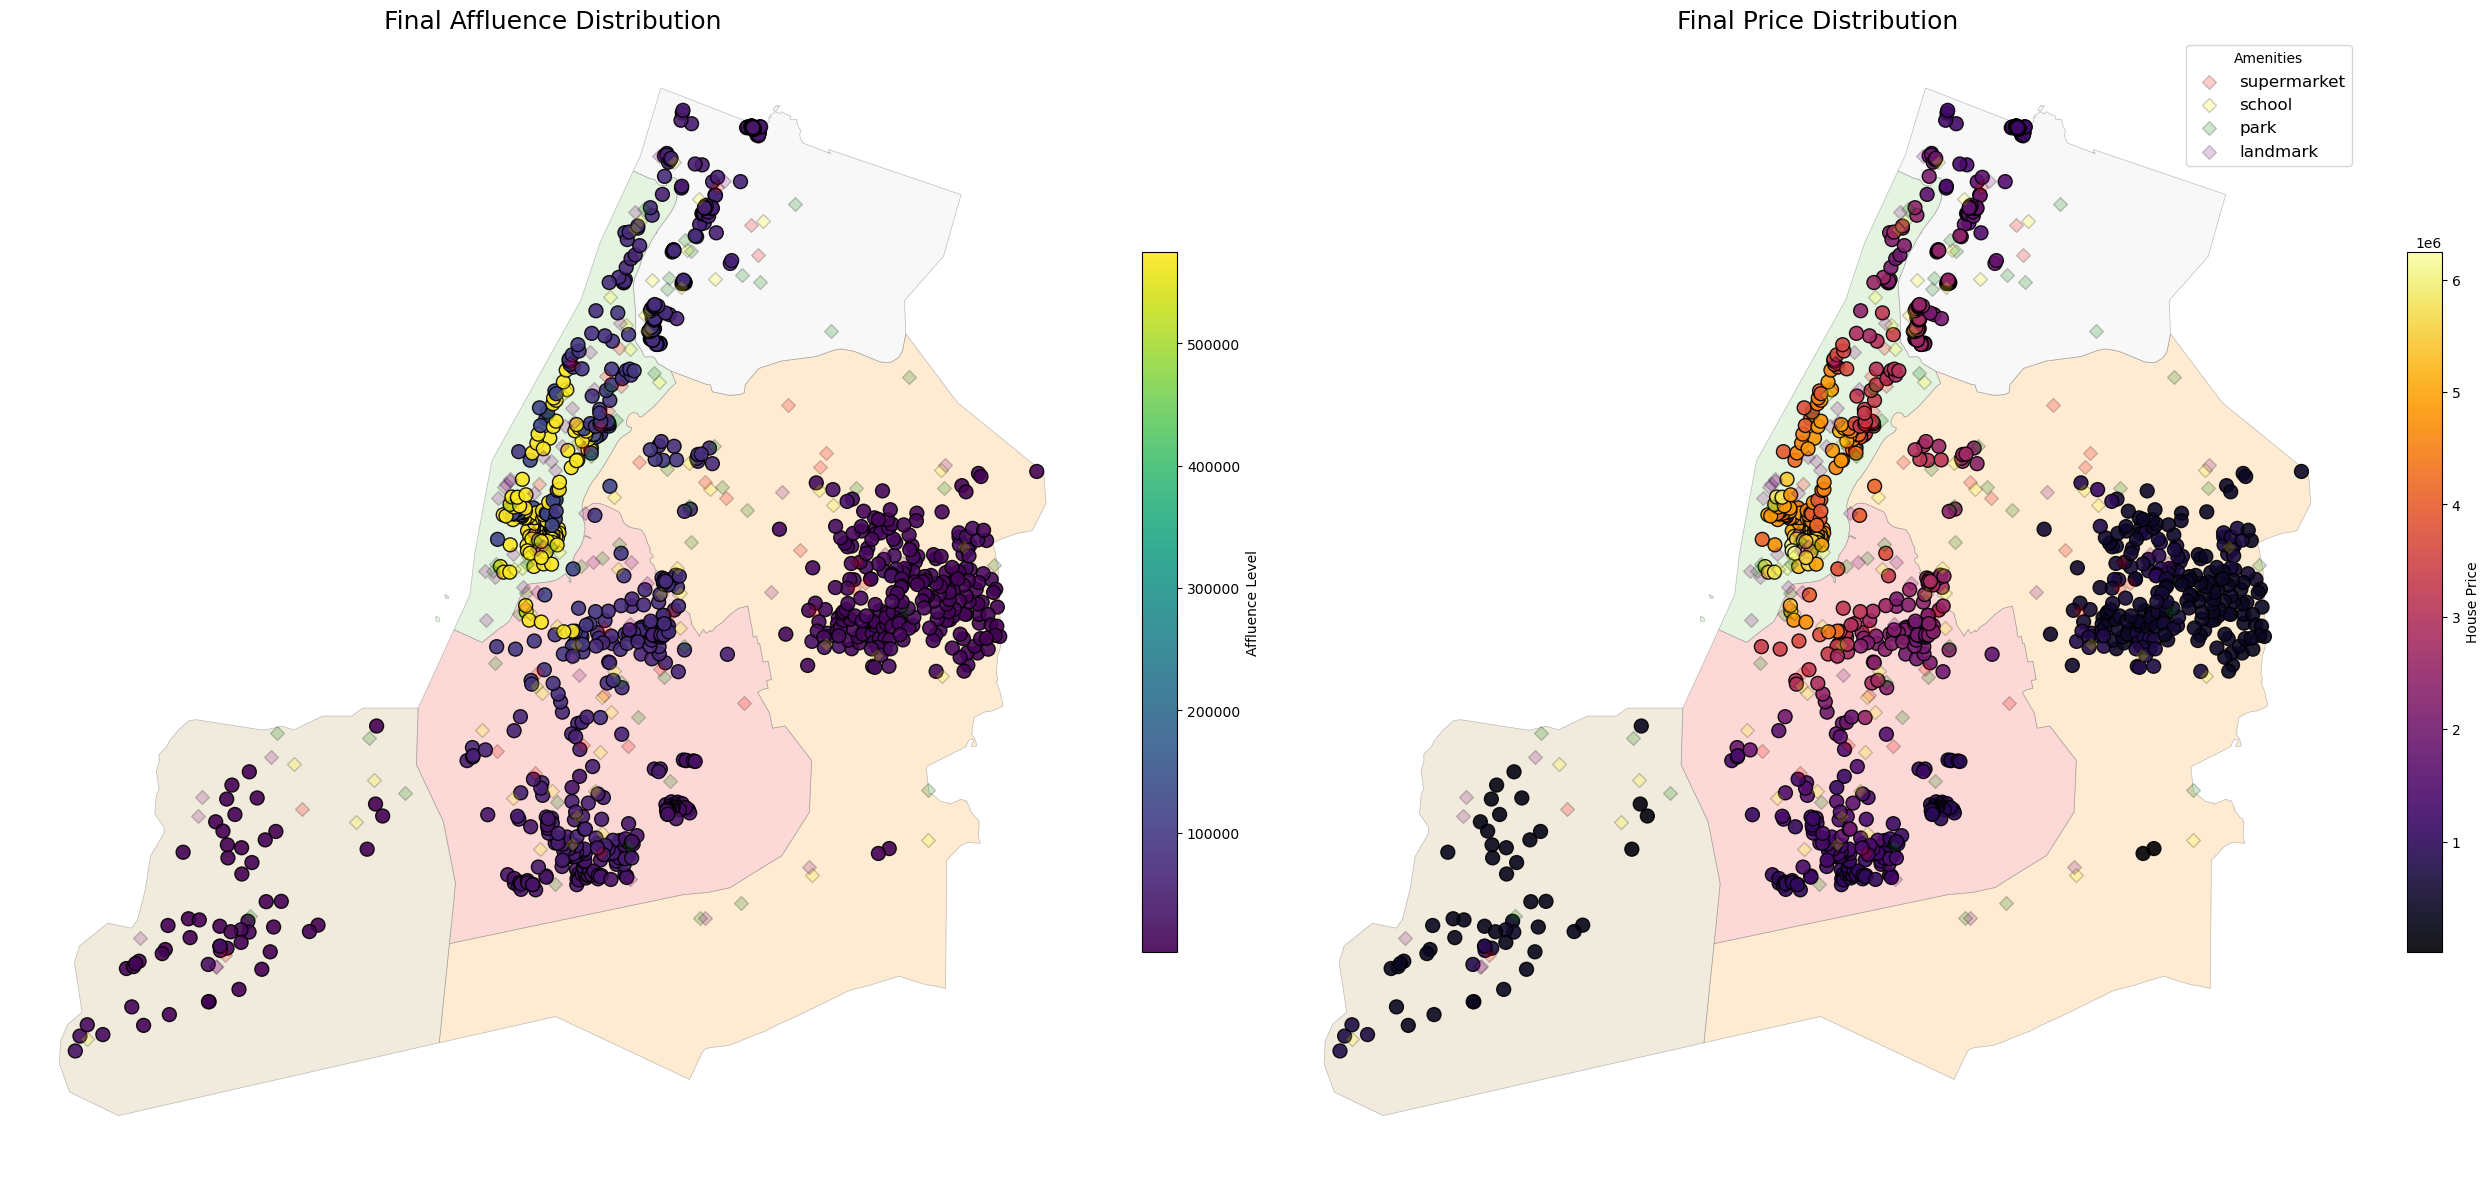

In [13]:
# Set up figure with two large subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 15), gridspec_kw = {'width_ratios': [1, 1]})

# Plot the residential areas and districts on both subplots

districts_within_city.plot(ax = ax1, column = 'District', cmap = 'Pastel1', edgecolor = 'gray', linewidth = 0.5, alpha = 0.5)
districts_within_city.plot(ax = ax2, column = 'District', cmap = 'Pastel1', edgecolor = 'gray', linewidth = 0.5, alpha = 0.5)

#residential_areas.plot(ax =ax1, color='lightgray', alpha=0.7)
#residential_areas.plot(ax = ax2, color='lightgray', alpha=0.7)

# Plot Amenities

# Scatter plot for ax1
for amenity_type, color in amenity_colors.items():
    # Filter model_amenities by amenity type
    filtered_amenities = model_amenities[model_amenities['Type'] == amenity_type]
    
    # Scatter plot with edge colors, marker style, and alpha set to 0.2 for transparency
    ax1.scatter(filtered_amenities['longitude'], filtered_amenities['latitude'], 
                edgecolors='k', marker='D', color=color, 
                label=amenity_type, s=50, zorder=5, alpha=0.2)

# Scatter plot for ax2
for amenity_type, color in amenity_colors.items():
    # Filter model_amenities by amenity type
    filtered_amenities = model_amenities[model_amenities['Type'] == amenity_type]
    
    # Scatter plot with edge colors, marker style, and alpha set to 0.2 for transparency
    ax2.scatter(filtered_amenities['longitude'], filtered_amenities['latitude'], 
                edgecolors='k', marker='D', color=color, 
                label=amenity_type, s=50, zorder=5, alpha=0.2)
        
# Plot the initial affluence distribution with a smaller color bar
scatter_affluence = ax1.scatter(vals['longitude'], vals['latitude'], 
                                c=vals['affluence'], cmap='viridis', s=100, 
                                edgecolors='k', alpha=0.9 )
ax1.set_title("Final Affluence Distribution", fontsize = 18)
cbar_affluence = fig.colorbar(scatter_affluence, ax=ax1, fraction=0.03, pad=0.04, label='Affluence Level')  # Smaller color bar
ax1.axis("off")
# Plot the initial price distribution with a smaller color bar
scatter_price = ax2.scatter(vals['longitude'], vals['latitude'], 
                            c=vals['price'], cmap='inferno', s=100, 
                            edgecolors='k', alpha=0.9)


ax2.set_title("Final Price Distribution", fontsize = 18)
plt.legend(loc='upper right', title="Amenities", fontsize=12)
cbar_price = fig.colorbar(scatter_price, ax=ax2, fraction=0.03, pad=0.04, label='House Price')  # Smaller color bar
ax2.axis("off")
plt.tight_layout()
plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


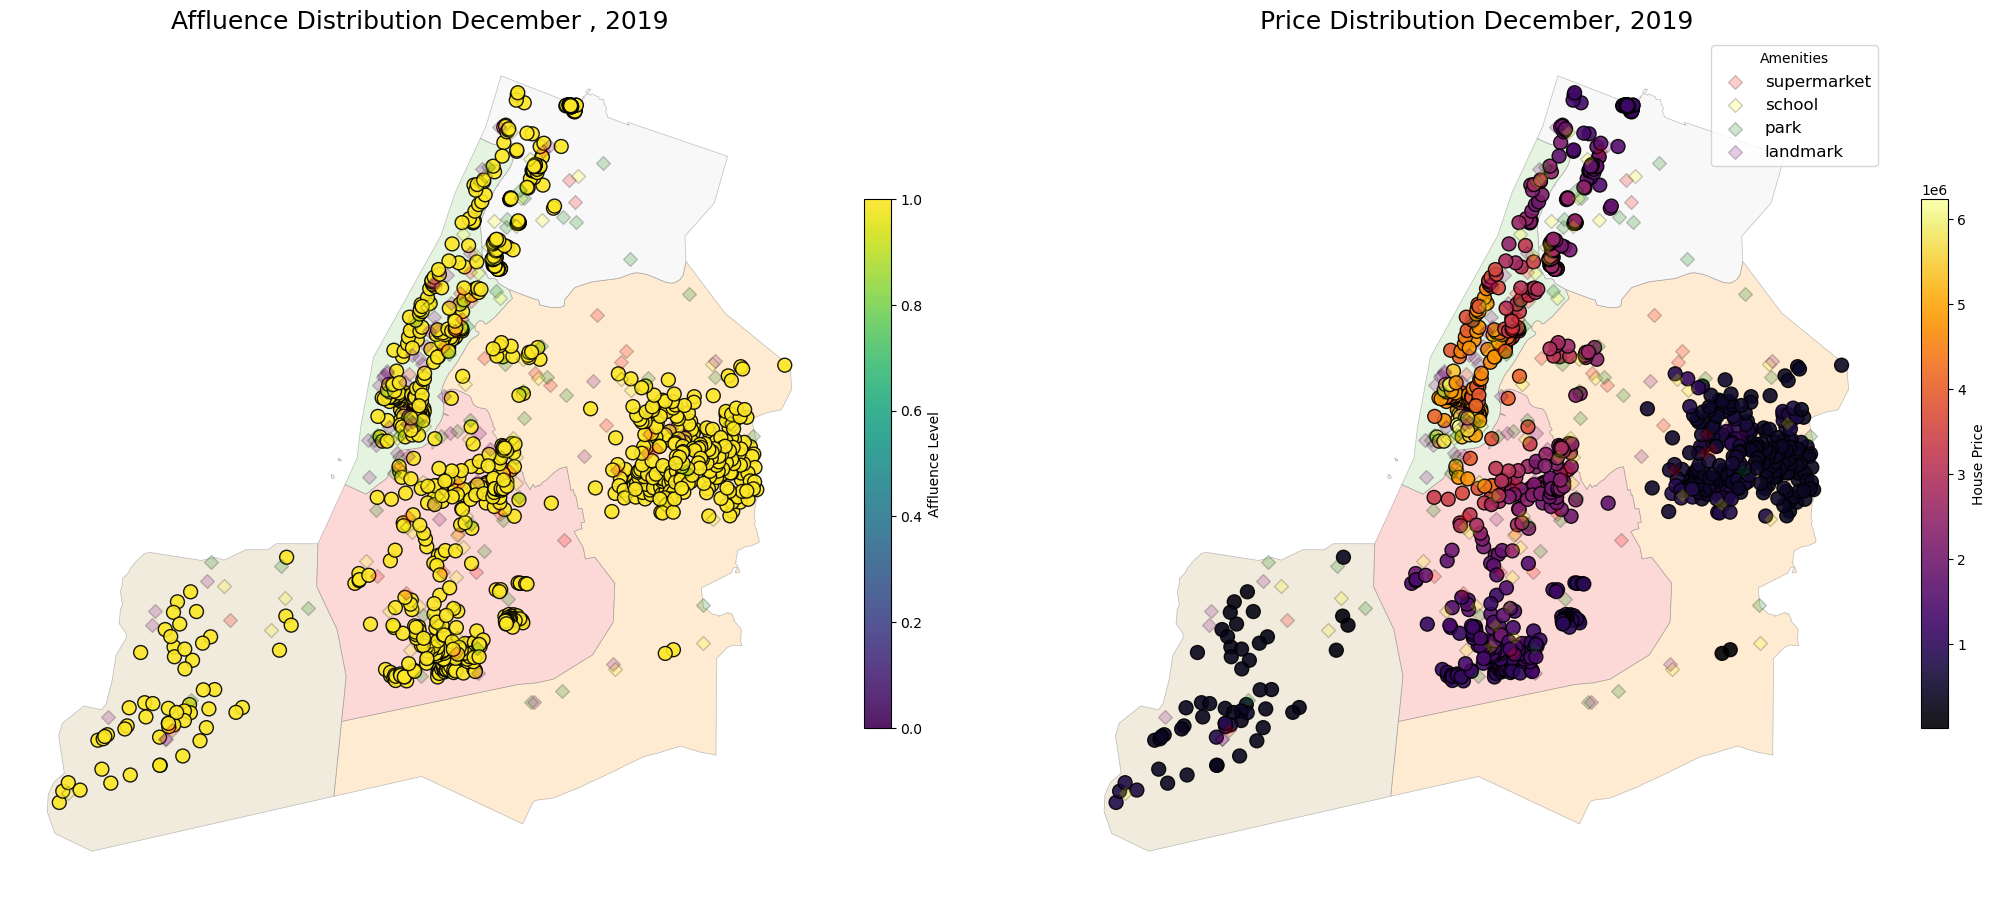

In [23]:
# Dimensions and parameters
time_steps = 23
half_months_per_year = 24  # 2 half-months per month, 12 months per year
current_year = year  # Year is stored in variable `year`

# Set up the figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 15), gridspec_kw={'width_ratios': [1, 1]})

# Plot districts and static amenities (these don't change over time)
districts_within_city.plot(ax=ax1, column='District', cmap='Pastel1', edgecolor='gray', linewidth=0.5, alpha=0.5)
districts_within_city.plot(ax=ax2, column='District', cmap='Pastel1', edgecolor='gray', linewidth=0.5, alpha=0.5)

for amenity_type, color in amenity_colors.items():
    filtered_amenities = model_amenities[model_amenities['Type'] == amenity_type]
    ax1.scatter(filtered_amenities['longitude'], filtered_amenities['latitude'], 
                edgecolors='k', marker='D', color=color, label=amenity_type, 
                s=50, zorder=5, alpha=0.2)
    ax2.scatter(filtered_amenities['longitude'], filtered_amenities['latitude'], 
                edgecolors='k', marker='D', color=color, label=amenity_type, 
                s=50, zorder=5, alpha=0.2)

# Static settings for the plot
ax1.set_title("Affluence Distribution Over Time", fontsize=18)
ax2.set_title("Price Distribution Over Time", fontsize=18)
ax1.axis("off")
ax2.axis("off")
plt.legend(loc='upper right', title="Amenities", fontsize=12)

# Initialize scatter plots for dynamic data
scatter_affluence = ax1.scatter([], [], c=[], cmap='viridis', s=100, edgecolors='k', alpha=0.9)
scatter_price = ax2.scatter([], [], c=[], cmap='inferno', s=100, edgecolors='k', alpha=0.9)

# Initialize colorbars
cbar_affluence = fig.colorbar(scatter_affluence, ax=ax1, fraction=0.03, pad=0.04, label='Affluence Level')
cbar_price = fig.colorbar(scatter_price, ax=ax2, fraction=0.03, pad=0.04, label='House Price')

# Function to calculate month and year for each frame
def calculate_date(frame):
    month_names = [
        "January", "February", "March", "April", "May", "June",
        "July", "August", "September", "October", "November", "December"
    ]
    month_index = (frame // 2) % 12  # Index for month (0-based)
    return month_names[month_index]

# Update function for animation
def update(frame):
    # Extract values for the current frame
    current_vals = saved_steps[frame]  # Assuming saved_steps is a list of DataFrames
    affluence = current_vals['affluence']
    price = current_vals['price']
    
    # Update scatter plot data for affluence without LogNorm (linear scale)
    scatter_affluence.set_offsets(current_vals[['longitude', 'latitude']].values)
    scatter_affluence.set_array(affluence)
    scatter_price.set_clim(vmin=affluence.min(), vmax=affluence.max())  # Adjust color scale for affluence
    # Update scatter plot data for price (you can keep the original scale for price if desired)
    scatter_price.set_offsets(current_vals[['longitude', 'latitude']].values)
    scatter_price.set_array(price)
    scatter_price.set_clim(vmin=price.min(), vmax=price.max())  # Adjust color scale for price
    
    # Update colorbars dynamically
    cbar_affluence.update_normal(scatter_affluence)
    cbar_price.update_normal(scatter_price)

    # Calculate and update titles with dynamic date
    date_label = calculate_date(frame)
    ax1.set_title(f"Affluence Distribution {date_label} , {year}", fontsize=18)
    ax2.set_title(f"Price Distribution {date_label}, {year}", fontsize=18)

    return scatter_affluence, scatter_price

# Create the animation
anim = FuncAnimation(fig, update, frames=time_steps, interval=1000, blit=False)

# Save animation as GIF
anim.save('agent_based_model_simulation.gif', fps=2)

plt.show()